# Summarizing General Content of Bitome

## Setup

### Import Required Packages

In [2]:
# built-in modules
from pathlib import Path
import sys

# third-party modules
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import seaborn as sns

BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())
from bitome.core import Bitome
from bitome.utilities import bits_per_bp_plot

### Set Global Variables

In [5]:
FIG_PATH = Path('..', 'figures', 'figure_2')
LOCAL_CACHE_PATH = Path('..', 'local_cache')

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

### Load Bitome KB 

In [7]:
test_bitome = Bitome.init_from_file(Path(LOCAL_CACHE_PATH, 'bitome.pkl'))
ori_start = test_bitome.origin.location.start.position

## Figures

### Column Bit Counts

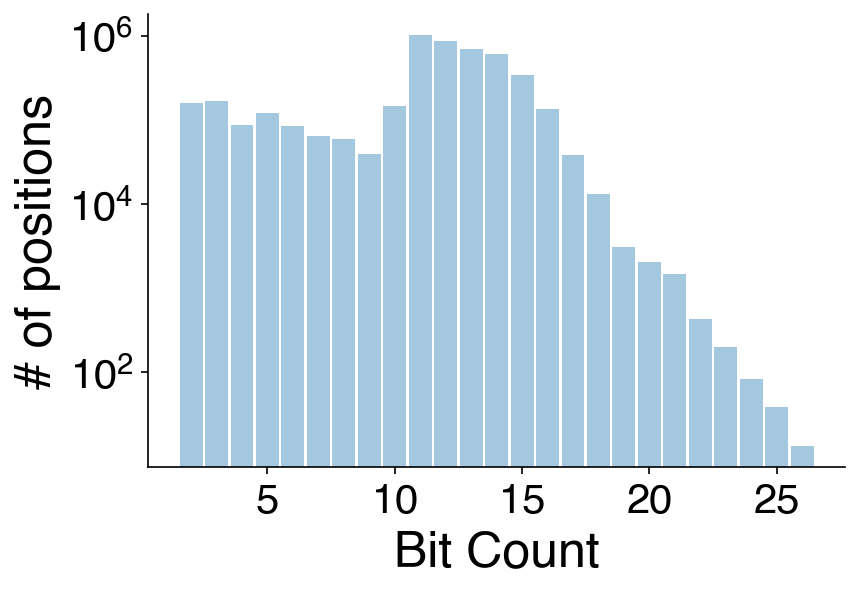

In [13]:
# --- histogram of nt byte sizes ---
column_sums = np.asarray(test_bitome.matrix.sum(axis=0)).flatten()
fig, ax = plt.subplots()
sns.distplot(
    column_sums,
    bins=25,
    kde=False,
    hist_kws={
        'log': True,
        'rwidth': 0.9,
        'range': (1.5, 26.5)
    },
    ax=ax
)
plt.xlabel('Bit Count', fontsize=24)
plt.ylabel('# of positions', fontsize=24)
plt.xticks([5, 10, 15, 20, 25])
ax.tick_params(axis='both', labelsize='20')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(Path(FIG_PATH, 'bits_per_col_hist.png'), bbox_inches='tight')
plt.show()

### Feature Coverages

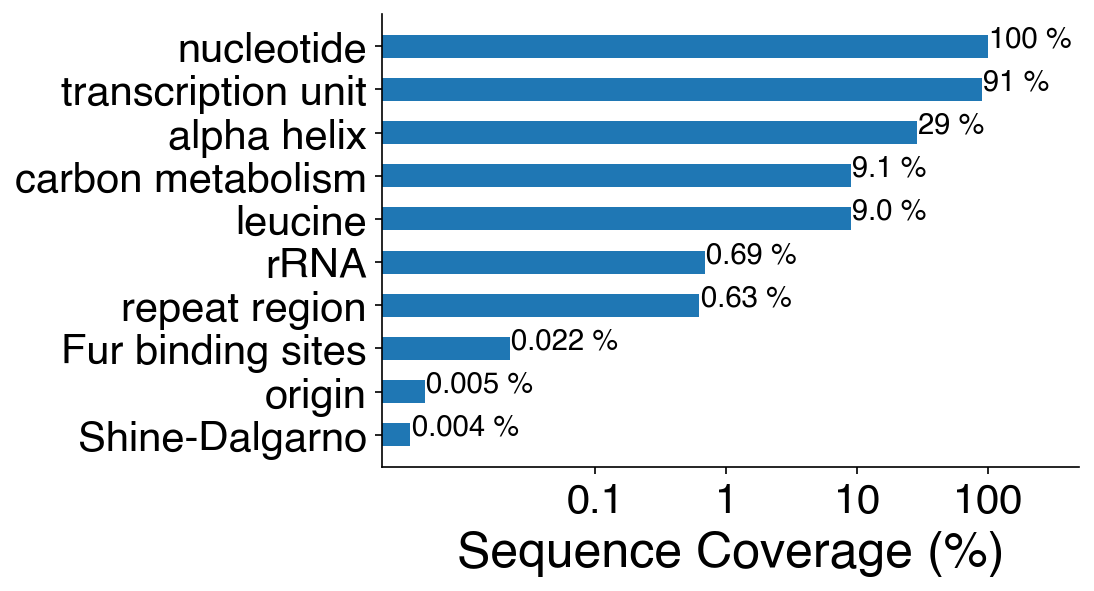

In [9]:
# --- sequence length occupation by features ---
features_to_extract = {
    'base': 'nucleotide',
    'TU': 'transcription unit',
    'secondary_structure_H': 'alpha helix',
    'ori': 'origin',
    'TFBS_Fur-Fe<SUP>2+</SUP>': 'Fur binding sites',
    'amino_acid_L': 'leucine',
    'COG_G': 'carbon metabolism',
    'gene_rRNA': 'rRNA',
    'Shine-Dalgarno': 'Shine-Dalgarno',
    'repeat_region': 'repeat region'
}
seq_length = len(test_bitome.sequence)
coverages = []
for feat_name in features_to_extract.keys():
    feat_mat = test_bitome.extract(row_labels=[feat_name], base_name=True)
    feat_vector = np.asarray(feat_mat.sum(axis=0)).flatten()
    coverages.append(len(np.where(feat_vector > 0)[0]))
coverage_pcts = (np.array(coverages)/seq_length)*100
sorted_tuples = sorted(zip(features_to_extract, coverage_pcts), key=lambda tup: tup[1])
sorted_final_names = [features_to_extract[tup[0]] for tup in sorted_tuples]
sorted_coverage_pcts = [tup[1] for tup in sorted_tuples]

y = np.arange(len(sorted_coverage_pcts)) * 1.5
fig, ax = plt.subplots()
plt.barh(y, sorted_coverage_pcts, log=True, tick_label=sorted_final_names)
plt.xlim(right=500)

for y_val, pct in zip(y, sorted_coverage_pcts):
    if pct > 10:
        label = f'{pct:.0f} %'
    elif pct > 1:
        label = f'{pct:.1f} %'
    elif pct >= 0.1:
        label = f'{pct:.2f} %'
    else:
        label = f'{pct:.3f} %'
    plt.text(pct*1.02, y_val, label, fontsize=14)


def x_axis_formatter(x, _):
    if x < 1:
        tick_label = f'{x:.1f}'
    else:
        tick_label = f'{x:.0f}'
    return tick_label


ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([0.1, 1, 10, 100])
ax.tick_params(axis='both', labelsize='20')
plt.xlabel('Sequence Coverage (%)', fontsize=24)
plt.savefig(Path(FIG_PATH, 'select_feature_coverages.png'), bbox_inches='tight')
plt.show()

### Bit Count across Genome

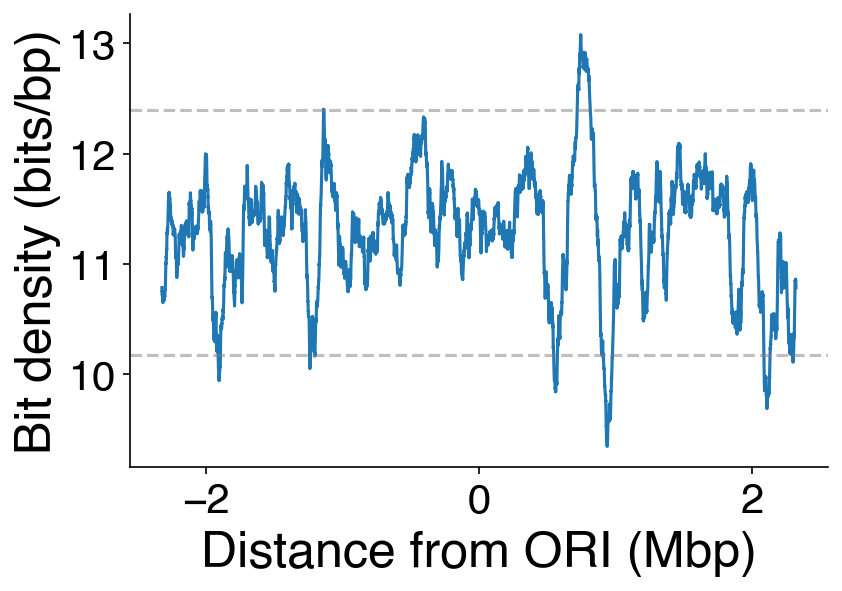

In [14]:
# --- information content moving average across genome ---
def information_content(matrix):
    matrix_col_sums = np.asarray(matrix.sum(axis=0)).flatten()
    left_end_info = int(len(matrix_col_sums) - 1 + ori_start - len(matrix_col_sums) / 2)
    right_end_info = int(len(matrix_col_sums) - 1 + ori_start + len(matrix_col_sums) / 2)
    info_moving_average = running_mean(
        np.concatenate([matrix_col_sums, matrix_col_sums, matrix_col_sums]), 100000
    )[left_end_info:right_end_info]
    return info_moving_average


def running_mean(x, n):
    cumsum = np.cumsum(x)
    return (cumsum[n:] - cumsum[:-n]) / float(n)


fig, ax = plt.subplots()
x_range = np.arange(-int(len(column_sums)/2), int(len(column_sums)/2), 1)/1000000
overall_info = information_content(test_bitome.matrix)
overall_mean = np.mean(overall_info)
overall_std = np.std(overall_info)
plt.plot(x_range, overall_info, label='all')
ax.axhline(overall_mean+2*overall_std, linestyle='--', color='gray', alpha=0.5)
ax.axhline(overall_mean-2*overall_std, linestyle='--', color='gray', alpha=0.5)
plt.xlabel('Distance from ORI (Mbp)', fontsize=24)
plt.ylabel('Bit density (bits/bp)', fontsize=24)
ax.tick_params(axis='both', labelsize='20')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(Path(FIG_PATH, 'info_content_average.svg'))
plt.show()

### (Supplemental) Feature-Specific Spatial Organizations

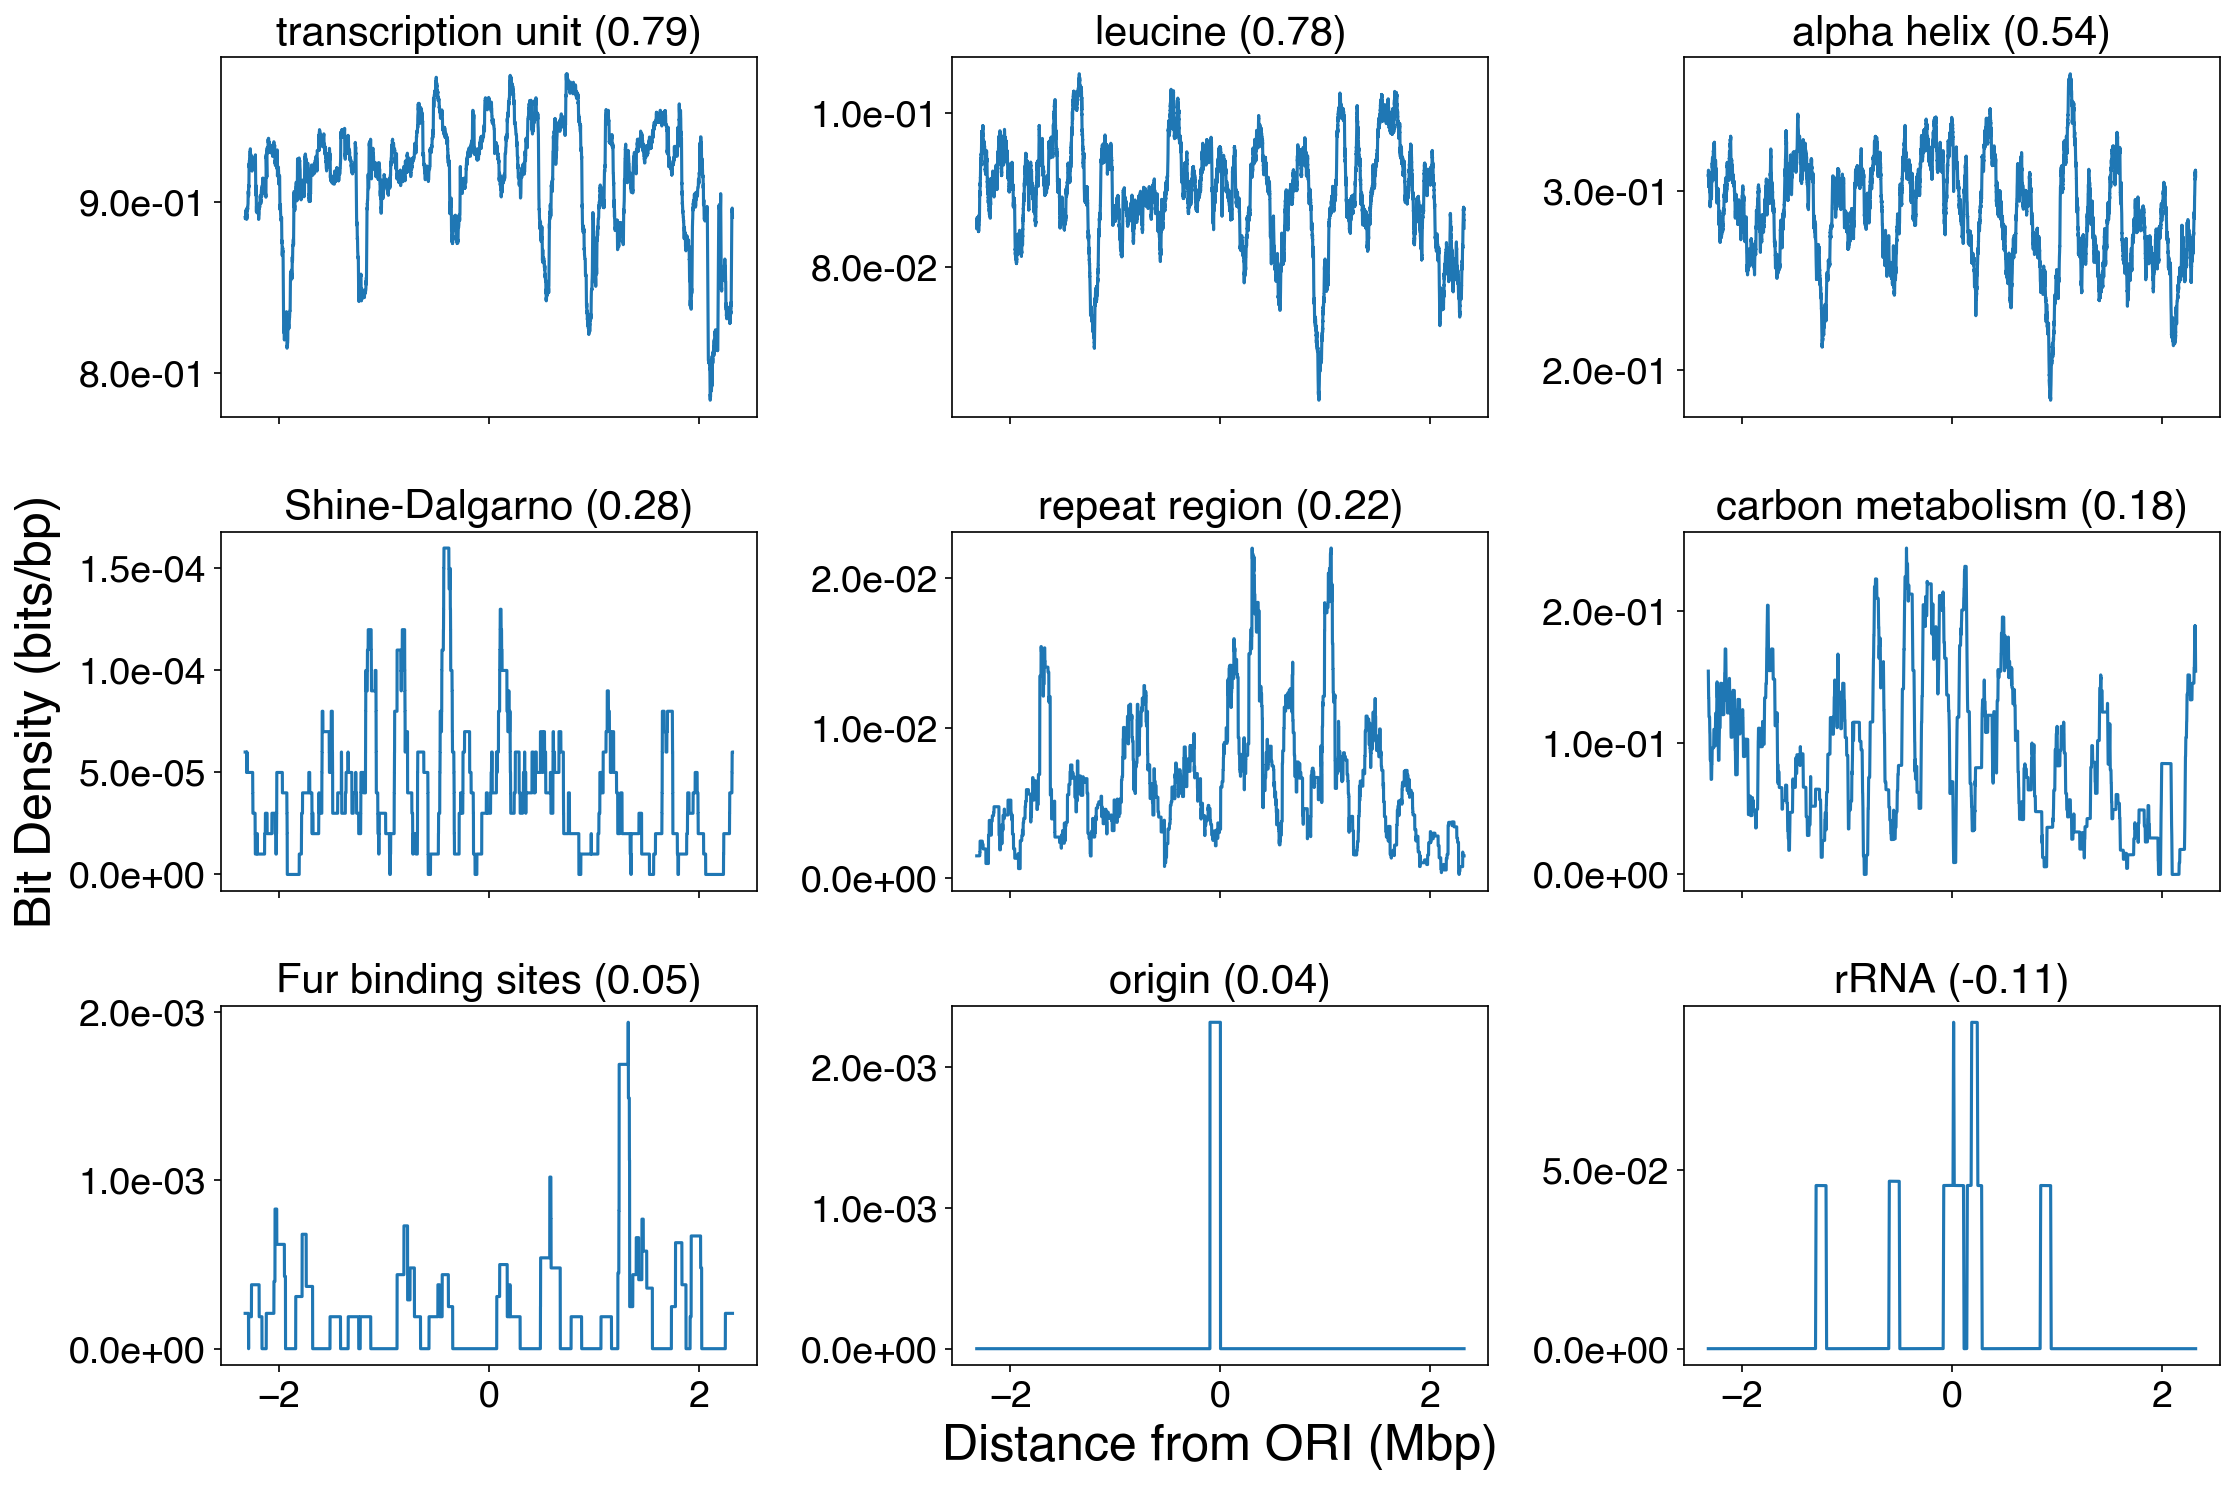

In [15]:
# --- backup: showing spatial organization of 10 selected features
features_to_extract_backup = features_to_extract.copy()
features_to_extract_backup.pop('base')

feat_infos = []
for feat_name in features_to_extract_backup.keys():
    feat_matrix = test_bitome.extract(row_labels=[feat_name], base_name=True)
    feat_info = information_content(feat_matrix)
    feat_infos.append(feat_info)

_, axs = plt.subplots(3, 3, figsize=(15, 10), sharex='all')
axs = axs.flatten()
overall_corrs = [pearsonr(feat_info, overall_info)[0] for feat_info in feat_infos]
feat_labels = features_to_extract_backup.values()
sorted_feat_infos, sorted_labels, sorted_corrs = zip(*sorted(
    zip(feat_infos, feat_labels, overall_corrs),
    key=lambda tup: tup[2],
    reverse=True
))
for feat_info, feat_label, corr, ax in zip(sorted_feat_infos, sorted_labels, sorted_corrs, axs):
    feat_info_z = (feat_info-np.mean(feat_info))/np.std(feat_info)
    ax.plot(x_range, feat_info)
    ax.set_title(f'{feat_label} ({corr:.2f})', fontsize=20)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    ax.set_xticks([-2, 0, 2])
    ax.tick_params(axis='both', labelsize=18)

axs[3].set_ylabel('Bit Density (bits/bp)', fontsize=24)
axs[7].set_xlabel('Distance from ORI (Mbp)', fontsize=24)
plt.tight_layout()
plt.savefig(Path(FIG_PATH, 'select_feature_info_avgs_supp.png'))
plt.show()

### Bit Density by Feature Type

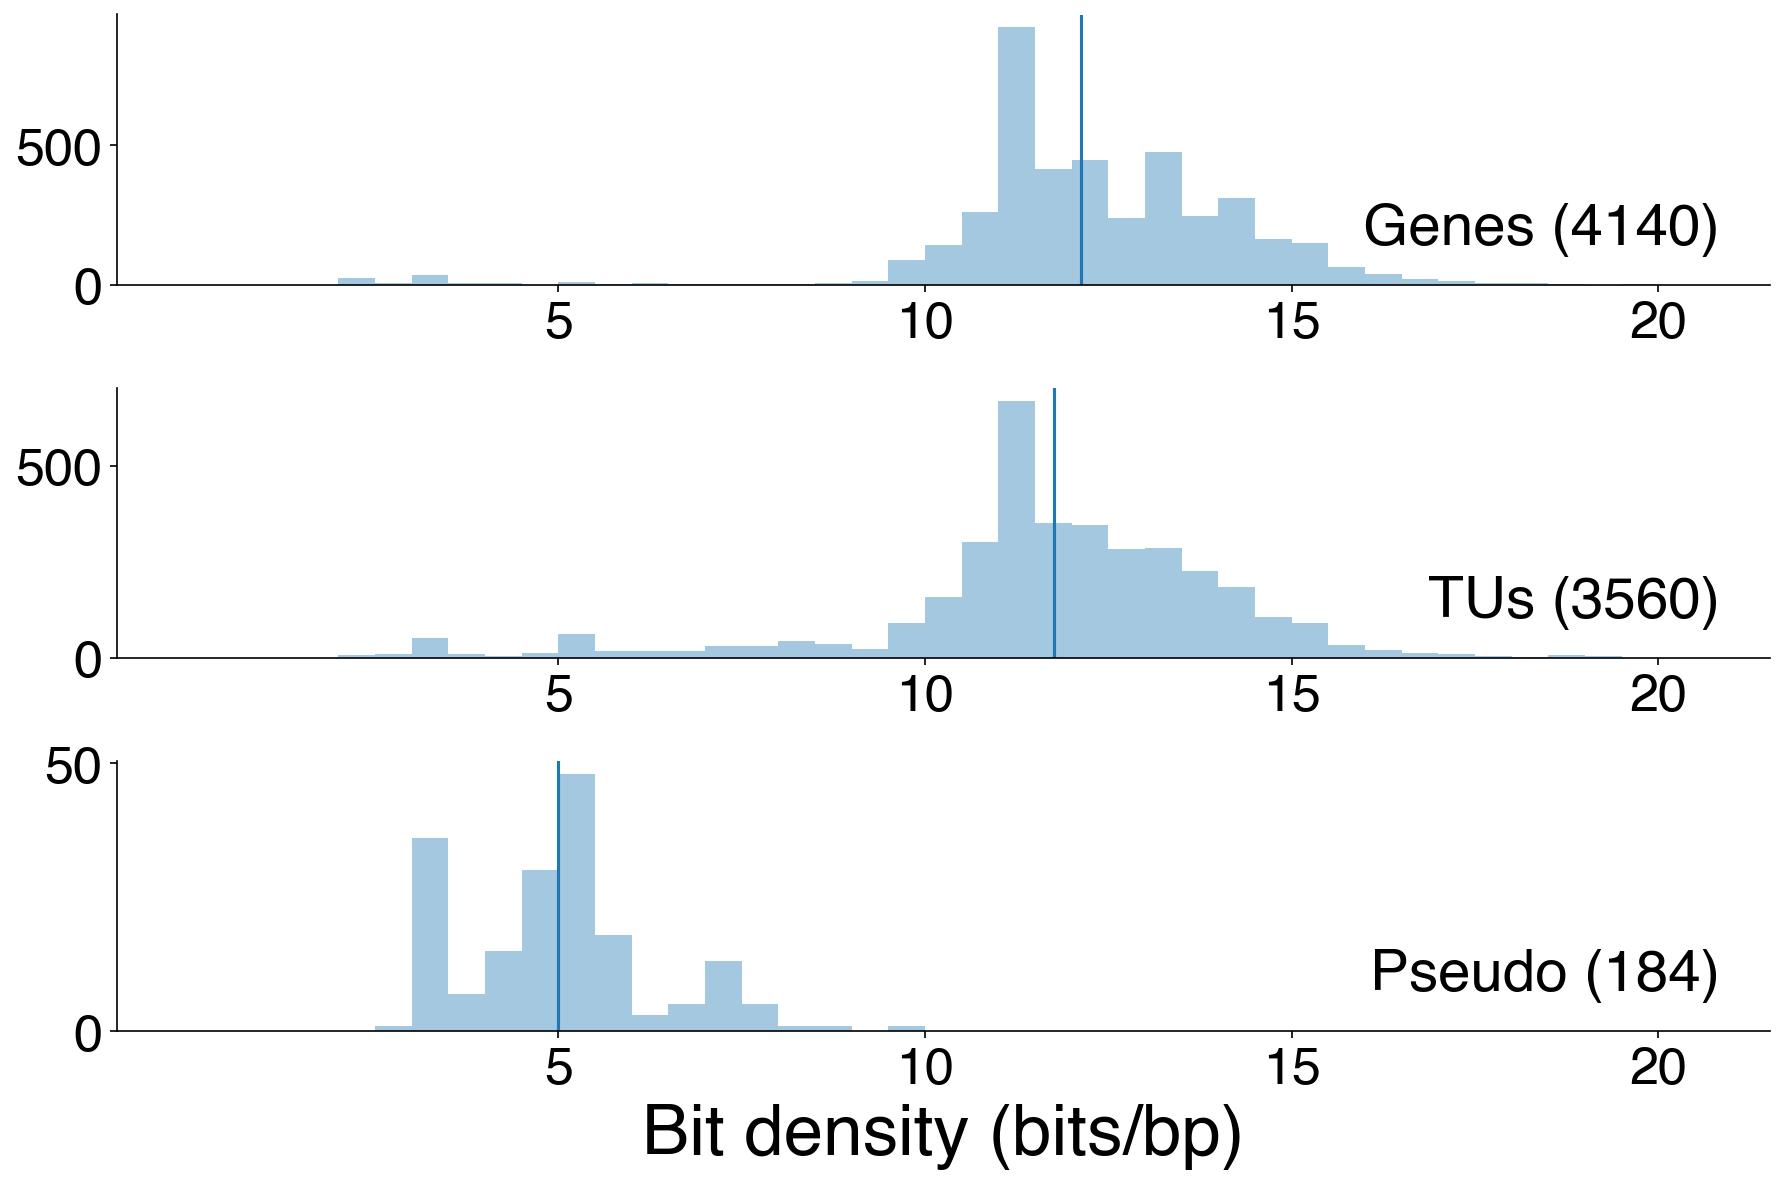

In [16]:
# --- information density by genes/TUs ---
all_genes = test_bitome.genes
coding_gene_ranges = [
    (gene.location.start.position, gene.location.end.position)
    for gene in all_genes if gene.gene_type == 'CDS'
]
pseudogene_ranges = [
    (gene.location.start.position, gene.location.end.position)
    for gene in all_genes if gene.gene_type == 'pseudo'
]
tu_ranges = [(tu.location.start.position, tu.location.end.position) for tu in test_bitome.transcription_units]

axs = bits_per_bp_plot(
    test_bitome,
    [coding_gene_ranges, tu_ranges, pseudogene_ranges],
    ['Genes', 'TUs', 'Pseudo'],
    show=False,
    median=True,
    kde=False,
    return_axs=True
)
axs[-1].set_xlabel('Bit density (bits/bp)', fontsize=34)
plt.savefig(Path(FIG_PATH, 'bits_per_bp_genes.svg'))
plt.show()

### Amino Acid/Secondary Structure Coverages

In [ ]:
# --- amino acid and secondary structure ---
def relative_feature_coverages(
            feature_name: str,
            feature_types: List[str],
            relative: bool = False
        ) -> Tuple[List[str], List[float]]:
    """
    Returns sorted feature types and coverages (as fraction of total base feature coverage)

    :param str feature_name: the base name of the feature
    :param List[str] feature_types: a list of the types this feature can have
    :param bool relative: indicates if the coverages should be relative to the whole genome or just the feature
    :return Tuple[List[str], List[float]] feature_type_coverages: the feature types and their associated coverages,
    sorted into descending order
    """

    if relative:
        total_matrix = test_bitome.extract(row_labels=['amino_acid'], base_name=True)
        total_zero_inds = np.where(total_matrix.sum(axis=0) == 0)[0]
        relative_coverage = 1 - (total_zero_inds.shape[0]/len(test_bitome.sequence))
    else:
        relative_coverage = 1
    feature_coverages = []
    for feature_type in feature_types:
        feature_matrix = test_bitome.extract(row_labels=[f'{feature_name}_{feature_type}'], base_name=True)
        zero_indices = np.where(feature_matrix.sum(axis=0) == 0)[0]
        coverage = 1 - (zero_indices.shape[0]/len(test_bitome.sequence))
        feature_coverages.append(100*coverage/relative_coverage)

    sorted_types, sorted_coverages = zip(*sorted(zip(feature_types, feature_coverages), key=lambda tup: tup[1]))
    return sorted_types, sorted_coverages


amino_acid_category_lookup = {
    'L': 'nonpolar',
    'A': 'nonpolar',
    'G': 'nonpolar',
    'V': 'nonpolar',
    'I': 'nonpolar',
    'E': 'charged',
    'S': 'polar',
    'R': 'charged',
    'T': 'polar',
    'D': 'charged',
    'P': 'nonpolar',
    'Q': 'polar',
    'K': 'charged',
    'F': 'nonpolar',
    'N': 'polar',
    'Y': 'polar',
    'M': 'nonpolar',
    'H': 'charged',
    'W': 'nonpolar',
    'C': 'polar'
}
amino_acids = IUPAC.protein.letters
sorted_aas, sorted_aa_coverages = relative_feature_coverages('amino_acid', amino_acids)

_, ax = plt.subplots()
x = np.arange(len(sorted_aa_coverages))
color_lookup = {'nonpolar': 'tab:gray', 'polar': 'tab:blue', 'charged': 'tab:red'}
colors = [color_lookup[amino_acid_category_lookup[aa]] for aa in sorted_aas]
plt.barh(x, sorted_aa_coverages, tick_label=sorted_aas, color=colors)
plt.xlabel('% of Sequence', fontsize=20)
plt.ylabel('Amino Acid', fontsize=20)
legend_elems = [Patch(facecolor=col, edgecolor=col, label=lab) for lab, col in color_lookup.items()]
ax.legend(handles=legend_elems, prop={'size': 16}, loc='lower right')
ax.tick_params(axis='both', labelsize=15)
plt.savefig(Path(FIG_PATH, 'amino_acid_coverage.svg'))
plt.show()

secondary_structures = ['B', 'E', 'I', 'G', 'H', 'T', 'S', '-']
sorted_ss, sorted_ss_coverages = relative_feature_coverages('secondary_structure', secondary_structures)
secondary_structure_names = {
    'B': 'beta bridge',
    'H': 'alpha helix',
    'E': 'beta strand',
    'G': '3-10 helix',
    'I': 'pi helix',
    'T': 'turn',
    'S': 'bend',
    '-': 'none'
}
secondary_structure_groups = {
    'B': 'beta sheet',
    'H': 'helix',
    'E': 'beta sheet',
    'G': 'helix',
    'I': 'helix',
    'T': 'loop',
    'S': 'loop',
    '-': 'loop'
}
_, ax = plt.subplots()
x = np.arange(len(sorted_ss_coverages))
plt.barh(x, sorted_ss_coverages, tick_label=[secondary_structure_names[ss] for ss in sorted_ss])
plt.xlabel('% of Sequence', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.savefig(Path(FIG_PATH, 'ss_coverage.svg'))
plt.show()

ss_aa_pcts = {}
for aa, ss in tqdm(product(amino_acids, secondary_structures)):
    overlap_len = 0
    ss_len = 0
    for rf in ['(+1)', '(+2)', '(+3)', '(-1)', '(-2)', '(-3)']:
        ss_matrix = test_bitome.extract(row_labels=[f'secondary_structure_{ss}_{rf}'], base_name=True)
        ss_inds = np.where(np.asarray(ss_matrix.sum(axis=0))[0] > 0)[0]
        aa_matrix = test_bitome.extract(row_labels=[f'amino_acid_{aa}_{rf}'], base_name=True)
        aa_inds = np.where(np.asarray(aa_matrix.sum(axis=0))[0] > 0)[0]
        overlap_len += len(set(list(ss_inds)).intersection(set(list(aa_inds))))
        ss_len += len(ss_inds)
    ss_group = secondary_structure_groups[ss]
    ss_group_size = sum([ss_group == ss_group_ref for ss_group_ref in secondary_structure_groups.values()])
    aa_pct_for_ss = (100*overlap_len/ss_len)/ss_group_size
    if ss_group in ss_aa_pcts:
        ss_aa_dict = ss_aa_pcts[ss_group]
    else:
        ss_aa_dict = {}
    if aa in ss_aa_dict:
        ss_aa_dict[aa] += aa_pct_for_ss
    else:
        ss_aa_dict[aa] = aa_pct_for_ss
    ss_aa_pcts[ss_group] = ss_aa_dict

_, axs = plt.subplots(1, len(ss_aa_pcts), sharey='all', figsize=(14, 7))
axs = axs.flatten()
for (ss, aa_pcts_dict), ax in zip(ss_aa_pcts.items(), axs):
    sorted_aas, sorted_aa_pcts = zip(*sorted(
        [(aa, pct) for aa, pct in aa_pcts_dict.items()],
        key=lambda tup: tup[1],
        reverse=True
    ))
    ax.bar(
        np.arange(len(sorted_aa_pcts)),
        sorted_aa_pcts,
        tick_label=sorted_aas,
        color=[color_lookup[amino_acid_category_lookup[aa]] for aa in sorted_aas]
    )
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(ss, loc='center', fontsize=24)
axs[1].set_xlabel('Amino Acid', fontsize=24)
axs[0].set_ylabel('% with Structure', fontsize=24)
plt.savefig(Path(FIG_PATH, 'aa_ss.svg'))
plt.show()

## Tables

### Feature Coverage Table

In [ ]:
# --- prepare supplemental table of all features, ordered by percentage coverage ---
row_coverages = (np.asarray(test_bitome.matrix.sum(axis=1)).flatten()/test_bitome.matrix.shape[1])*100
sorted_row_coverages, sorted_row_names = zip(*sorted(
    zip(row_coverages, test_bitome.matrix_row_labels),
    key=lambda tup: tup[0],
    reverse=True
))

# nice-ify the percentages
sorted_row_coverages_nice = []
for row_pct in sorted_row_coverages:
    if row_pct > 10:
        nice_pct = np.around(row_pct, decimals=0)
    elif row_pct > 1:
        nice_pct = np.around(row_pct, decimals=1)
    elif row_pct > 0.1:
        nice_pct = np.around(row_pct, decimals=2)
    elif row_pct > 0.01:
        nice_pct = np.around(row_pct, decimals=3)
    elif row_pct > 0.001:
        nice_pct = np.around(row_pct, decimals=4)
    elif row_pct > 0.0001:
        nice_pct = np.around(row_pct, decimals=5)
    elif row_pct > 0.00001:
        nice_pct = np.around(row_pct, decimals=6)
    else:
        nice_pct = np.around(row_pct, decimals=0)
    sorted_row_coverages_nice.append(nice_pct)

row_sum_df = pd.DataFrame(data={'Row Label': sorted_row_names, 'Coverage (%)': sorted_row_coverages_nice})
row_sum_df.to_csv(Path(FIG_PATH, 'sorted_row_coverages.csv'))

all_base_names = []
for feature_name in test_bitome.feature_names:
    row_labels_with_name = [row_label for row_label in test_bitome.matrix_row_labels if feature_name in row_label]
    if feature_name in ['base', 'gene', 'residue_exposure', 'codon', 'COG', 'secondary_structure', 'amino_acid',
                        'operon', 'TU', 'TTS', 'protein', 'riboswitch', '-35_box', 'promoter', 'TSS',
                        'attenuator_translation', 'Shine-Dalgarno', 'terminator_rho', 'attenuator_transcription',
                        'terminator', '-10_box', 'mobile_element', 'repeat_region']:
        row_labels_no_frame = [label[:-5] for label in row_labels_with_name]
        all_base_names += list(set(row_labels_no_frame))
    elif feature_name in ['i-modulon', 'regulon', 'sigmulon', 'TFBS']:
        all_base_names += row_labels_with_name
    elif feature_name in ['mRNA_structure', 'origin']:
        all_base_names.append(feature_name)
    else:
        print('DANGER')